In [1]:
# Import Python modules

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Machine learning modules

from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [3]:
# Read clinical trials data 
file_path = './data/vaccine_trials.csv'
vaccine_trials = pd.read_csv(file_path, index_col=0)

# Filter completed studies and create a copy
vax_trials_filtered = vaccine_trials[vaccine_trials['OverallStatus'] == 'Completed'].copy()

# Drop 'Rank' column
vax_trials_filtered.drop('Rank', axis=1, inplace=True)

# Display the DataFrame
vax_trials_filtered.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus
0,NCT00478816,Phase 2,Prophylaxis of Avian Influenza Vaccine,58,Completed
2,NCT03771157,Early Phase 1,Chronic Lymphocytic Leukemia (CLL)|Waldenstrom...,33,Completed
3,NCT03057483,NaN,Influenza Vaccines,533,Completed
4,NCT00735410,Phase 3,"Seasonal Influenza, Vaccine",134,Completed
5,NCT00103116,Phase 2,Lung Cancer,32,Completed


### Explore and clean the vaccine clinical trials dataset

In [4]:
# Check for duplicates
duplicates = vax_trials_filtered.duplicated()
print(duplicates.value_counts())

False    707
dtype: int64


In [5]:
# Remove the duplicates
#vax_trials_filtered = vax_trials_filtered.drop_duplicates()

In [6]:
# Print information about the DataFrame
vax_trials_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 0 to 998
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   NCTId            707 non-null    object
 1   Phase            666 non-null    object
 2   Condition        707 non-null    object
 3   EnrollmentCount  707 non-null    int64 
 4   OverallStatus    707 non-null    object
dtypes: int64(1), object(4)
memory usage: 33.1+ KB


In [7]:
# Count unique events per column
unique_counts = vax_trials_filtered.nunique()
unique_counts

NCTId              707
Phase                8
Condition          386
EnrollmentCount    439
OverallStatus        1
dtype: int64

In [8]:
# Summary statistics
#vax_trials_filtered.describe(include = 'all')
vax_trials_filtered.describe()

,EnrollmentCount
count,7.070000e+02
mean,4.373440e+03
std,5.899884e+04
min,1.000000e+00
25%,6.300000e+01
50%,2.220000e+02
75%,6.640000e+02
max,1.534706e+06


- standardize the names in the 'Condition' column by converting them all to the same format

In [9]:
unique_names = vax_trials_filtered['Condition'].unique()
unique_names

array(['Prophylaxis of Avian Influenza Vaccine',
       'Chronic Lymphocytic Leukemia (CLL)|Waldenstrom Macroglobulinemia (WM)',
       'Influenza Vaccines', 'Seasonal Influenza, Vaccine', 'Lung Cancer',
       'Vaccine Acceptance', 'Influenza', 'Plague Vaccine',
       'Prepandemic Influenza Vaccine', 'Seasonal Influenza|Vaccine',
       'Botulism Vaccine', 'Non-Small Cell Lung Cancer',
       'Influenza|Vaccine Virus Shedding', 'Seasonal Influenza Vaccine',
       'Narcolepsy', 'Dengue Virus', 'Rubella|Measles',
       'Seasonal Influenza',
       'Meningitis|Meningococcal Meningitis|Meningococcal Infections',
       'Glioblastoma', 'Influenza Disease', 'Covid19|Vaccines',
       'Newborn Vaccine Immunogenicity', 'Pandemic Influenza Disease',
       'Japanese Encephalitis|Japanese Encephalitis Vaccine',
       'Meningococcal Meningitis',
       'Vaccine Adverse Reaction|COVID-19|Vaccine Reaction',
       'Prevention of Meningococcal Disease',
       'Patient Response to Fluzone ID Va

In [10]:
# convert all the strings in the 'Condition' column to lowercase
vax_trials_filtered['Condition'] = vax_trials_filtered['Condition'].str.lower()

In [11]:
# Define the mapping dictionary
mapping = {
    'influenza': 'influenza',
    'meningococcal': 'meningococcal',
    'sars-cov-2': 'sars-cov-2',
    'covid': 'sars-cov-2',
    'dengue': 'dengue',
    'hand': 'hand-foot-mouth disease',
    'hpv': 'hpv',
    'hiv': 'hiv',
    'papilomavirus': 'papilomavirus',
    'pneumo': 'pneumococcal',
    'streptococcal': 'streptococcal'
    
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials_filtered.loc[vax_trials_filtered['Condition'].str.contains(old_value), 'Condition'] = new_value

In [12]:
# Remove the clinical trials with the condition: 'vaccine adverse reaction'

# Filter rows 
vax_trials_filtered = vax_trials_filtered.loc[~vax_trials_filtered['Condition'].str.contains('vaccine adverse reaction', case=False)]

# Reset index
vax_trials_filtered.reset_index(drop=True, inplace=True)


In [13]:
# Remove the clinical trials with the condition: 'healthy'

# Filter rows 
vax_trials_filtered = vax_trials_filtered.loc[~vax_trials_filtered['Condition'].str.contains('healthy', case=False)]

# Reset index
vax_trials_filtered.reset_index(drop=True, inplace=True)


### Retrieve data from AACT

1. Use this link: [AACT Download](https://aact.ctti-clinicaltrials.org/download)
2. Select pipe-delimited files.
3. Download the latest version of the "Current Month's Daily Static Copies."

- You can find information about each table in the AACT dataset [here](https://aact.ctti-clinicaltrials.org/data_dictionary).



#### drop_withdrawals.txt

- Summarized information about how many participants withdrew from the study, when and why. This information explains disposition of participants relative to the numbers starting and completing the study (enumerated in the Milestones table)

In [14]:
# Read drop_withdrawals file from AACT database
file_path = './AACT_20240125/drop_withdrawals.txt'

# select only the nct_id, reason, and count columns
drop_withdrawals = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,6])

# Rename nct_id column to NCTId 
drop_withdrawals = drop_withdrawals.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
drop_withdrawals.head()

,NCTId,reason,count
0,NCT01443026,Physician Decision,1.0
1,NCT01443026,Physician Decision,0.0
2,NCT01443026,Death,0.0
3,NCT01443026,Death,1.0
4,NCT01443026,Withdrawal by Subject,0.0


#### milestones.txt

- Information summarizing the progress of participants through each stage of a study, including the number of participants who started and completed the trial. Enumeration of participants not completing the study is included in the Drop_Withdrawals table.

In [15]:
# Read milestones file from AACT database
file_path = './AACT_20240125/milestones.txt'

# select only the nct_id, title, and count columns
milestones = pd.read_csv(file_path, header=0, sep="|", usecols=[1,4,7])

# Rename nct_id column to NCTId 
milestones = milestones.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
milestones.head()

,NCTId,title,count
0,NCT02829723,STARTED,5.0
1,NCT02829723,STARTED,7.0
2,NCT03907579,STARTED,100.0
3,NCT03074500,STARTED,11.0
4,NCT03074500,STARTED,11.0


#### interventions.txt
- The interventions or exposures (including drugs, medical devices, procedures, vaccines, and other products) of interest to the study, or associated with study arms/groups.

In [16]:
# Read interventions file from AACT database
file_path = './AACT_20240125/interventions.txt'

# select only the nct_id, title, and count columns
interventions = pd.read_csv(file_path, header=0, sep="|", usecols=[1,2,3])

# Rename nct_id column to NCTId 
interventions = interventions.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
interventions.head()

,NCTId,intervention_type,name
0,NCT03182764,Other,No intervention
1,NCT05916014,Diagnostic Test,Diagnostic Test: The diagnosis of Artificial I...
2,NCT05916001,Other,Placebo
3,NCT00195676,Drug,adalimumab
4,NCT00228332,Drug,Administration of zinkgluconaat or placebo


#### reported_events.txt
- Summary information about reported adverse events (any untoward or unfavorable medical occurrence to participants, including abnormal physical exams, laboratory findings, symptoms, or diseases), including serious adverse events, other adverse events, and mortality.

In [17]:
# Read interventions file from AACT database
file_path = './AACT_20240125/reported_events.txt'

# select only the nct_id, title, and count columns
reported_events = pd.read_csv(file_path, header=0, sep="|", usecols=[1,5,8,9,11,13,14])

# Rename nct_id column to NCTId 
reported_events = reported_events.rename(columns={"nct_id": "NCTId"})

# Display the DataFrame
reported_events.head()

,NCTId,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT02305888,serious,1.0,63,NaN,Inguinal hernia,3.0
1,NCT02305888,serious,0.0,63,NaN,Inguinal hernia,3.0
2,NCT02305888,serious,0.0,62,NaN,Inguinal hernia,3.0
3,NCT02305888,other,28.0,63,NaN,Application site pain,3.0
4,NCT01026402,other,0.0,8,0.0,Hypoalbuminaemia,5.0


#### Merge the AACT data with the ClinicalTrials data

In [18]:
# define function to merge two dfs

def merge_data(df1, df2, id):
    merged_df = pd.merge(df1, df2, on=id)
    return merged_df

In [19]:
# Merge the vaccine clinical trials file with the drop withdrawals file on the NCT Id
vax_trials_with_dropouts = merge_data(vax_trials_filtered, drop_withdrawals, 'NCTId')
vax_trials_with_dropouts.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,reason,count
0,NCT02915302,Phase 4,influenza,1950,Completed,Adverse Event,3.0
1,NCT02915302,Phase 4,influenza,1950,Completed,Adverse Event,0.0
2,NCT02915302,Phase 4,influenza,1950,Completed,Protocol Violation,20.0
3,NCT02915302,Phase 4,influenza,1950,Completed,Protocol Violation,27.0
4,NCT02915302,Phase 4,influenza,1950,Completed,Lost to Follow-up,19.0


In [20]:
# Rename columns for clarity
vax_trials_with_dropouts = vax_trials_with_dropouts.rename(columns={'reason':'Reason', 'count':'DropoutCount'})
vax_trials_with_dropouts.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Reason,DropoutCount
0,NCT02915302,Phase 4,influenza,1950,Completed,Adverse Event,3.0
1,NCT02915302,Phase 4,influenza,1950,Completed,Adverse Event,0.0
2,NCT02915302,Phase 4,influenza,1950,Completed,Protocol Violation,20.0
3,NCT02915302,Phase 4,influenza,1950,Completed,Protocol Violation,27.0
4,NCT02915302,Phase 4,influenza,1950,Completed,Lost to Follow-up,19.0


In [21]:
# Merge the vaccine clinical trials file with the milestones file on the NCT Id
vax_trials_with_milestones = merge_data(vax_trials_filtered, milestones, 'NCTId')
vax_trials_with_milestones.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,title,count
0,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,STARTED,32.0
1,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,COMPLETED,31.0
2,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,NOT COMPLETED,1.0
3,NCT00103116,Phase 2,lung cancer,32,Completed,STARTED,32.0
4,NCT00103116,Phase 2,lung cancer,32,Completed,COMPLETED,32.0


In [22]:
# Rename columns for clarity
vax_trials_with_milestones = vax_trials_with_milestones.rename(columns={'title':'Status', 'count':'StatusCount'})
vax_trials_with_milestones.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Status,StatusCount
0,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,STARTED,32.0
1,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,COMPLETED,31.0
2,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,NOT COMPLETED,1.0
3,NCT00103116,Phase 2,lung cancer,32,Completed,STARTED,32.0
4,NCT00103116,Phase 2,lung cancer,32,Completed,COMPLETED,32.0


In [23]:
# Merge the vaccine clinical trials file with the interventions file on the NCT Id
vax_trials_with_interventions = merge_data(vax_trials_filtered, interventions, 'NCTId')
vax_trials_with_interventions.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,intervention_type,name
0,NCT00478816,Phase 2,influenza,58,Completed,Biological,Fluad H5N1 Pandemic Influenza Vaccine
1,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,Drug,Shingrix vaccine
2,NCT03057483,NaN,influenza,533,Completed,Biological,Seasonal Influenza vaccine
3,NCT00735410,Phase 3,influenza,134,Completed,Biological,Seasonal Influenza Vaccine
4,NCT00103116,Phase 2,lung cancer,32,Completed,Biological,autologous dendritic cell cancer vaccine


In [24]:
# Rename columns for clarity
vax_trials_with_interventions = vax_trials_with_interventions.rename(columns={'intervention_type':'InterventionType', 'name':'VaccineName'})
vax_trials_with_interventions.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,InterventionType,VaccineName
0,NCT00478816,Phase 2,influenza,58,Completed,Biological,Fluad H5N1 Pandemic Influenza Vaccine
1,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,Drug,Shingrix vaccine
2,NCT03057483,NaN,influenza,533,Completed,Biological,Seasonal Influenza vaccine
3,NCT00735410,Phase 3,influenza,134,Completed,Biological,Seasonal Influenza Vaccine
4,NCT00103116,Phase 2,lung cancer,32,Completed,Biological,autologous dendritic cell cancer vaccine


In [25]:
# Merge the vaccine clinical trials file with the reported_events file on the NCT Id
vax_trials_with_ae = merge_data(vax_trials_filtered, reported_events, 'NCTId')
vax_trials_with_ae.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,event_type,subjects_affected,subjects_at_risk,event_count,adverse_event_term,frequency_threshold
0,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,serious,1.0,32,1.0,Atrial fibrillation,0.0
1,NCT00103116,Phase 2,lung cancer,32,Completed,other,16.0,32,16.0,injection site reaction,1.0
2,NCT02915302,Phase 4,influenza,1950,Completed,serious,0.0,949,NaN,Cellulitis,5.0
3,NCT02915302,Phase 4,influenza,1950,Completed,serious,1.0,992,NaN,Cellulitis,5.0
4,NCT02915302,Phase 4,influenza,1950,Completed,serious,1.0,949,NaN,Pneumonia,5.0


In [26]:
# Rename columns for clarity
vax_trials_with_ae = vax_trials_with_ae.rename(columns={'event_type':'EventType', 'subjects_affected':'SubjectsAffected', 'subjects_at_risk':'SubjectsAtRisk', 'adverse_event_term':'AdverseEvemt'})
vax_trials_with_ae.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,EventType,SubjectsAffected,SubjectsAtRisk,event_count,AdverseEvemt,frequency_threshold
0,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,serious,1.0,32,1.0,Atrial fibrillation,0.0
1,NCT00103116,Phase 2,lung cancer,32,Completed,other,16.0,32,16.0,injection site reaction,1.0
2,NCT02915302,Phase 4,influenza,1950,Completed,serious,0.0,949,NaN,Cellulitis,5.0
3,NCT02915302,Phase 4,influenza,1950,Completed,serious,1.0,992,NaN,Cellulitis,5.0
4,NCT02915302,Phase 4,influenza,1950,Completed,serious,1.0,949,NaN,Pneumonia,5.0


#### Cleaning the data

In [27]:
unique_names = vax_trials_with_dropouts['Reason'].unique()
unique_names

array(['Adverse Event', 'Protocol Violation', 'Lost to Follow-up',
       'Withdrawal by Subject', 'Other', 'Death', 'Administrative reason',
       'Missing primary reason', 'Serious Adverse Event',
       'Administrative Reasons', 'Unable to Classify',
       'Unable to classify', 'Administrative Reason',
       'Physician Decision', 'Move from study area',
       'To militarycamp for conscript', 'To drug therapy course',
       'Move to work oversea', 'Premature Withdrawal',
       'Father in hospital', 'Migrated/moved from study area',
       'Off study due to infection', 'Inappropriate enrollment',
       'Non-compliance with the protocol',
       'Subject met exclusion criteria',
       'Visit 1 delayed, unable to reschedule',
       'Met exclusion criterion No 6', 'Subject moved out of the state',
       'Baseline measles measure high', 'Did not receive allocation',
       'Insufficient blood sample', 'Not Eligible',
       'Received 2 doses of vaccine',
       'Enrolled both ye

In [28]:
# convert all the strings in the 'Reason' column to lowercase

vax_trials_with_dropouts['Reason'] = vax_trials_with_dropouts['Reason'].str.lower()

In [29]:
# Define a mapping dictionary
mapping = {
    'adverse events': 'adverse event',
    'administrative reasons': 'administrative reason',
    'adverse event or death': 'ae or death',
    'failure to return': 'failed to return'
}

# Apply the mapping to the column
vax_trials_with_dropouts['Reason'] = vax_trials_with_dropouts['Reason'].replace(mapping)

In [30]:
# Define the mapping dictionary
mapping = {
    'move': 'relocate',
    'moved': 'relocate',
    'other': 'others',
    'exclusion': 'met exclusion criteria',
    'non compliance': 'protocol violation/deviation',
    'violation': 'protocol violation/deviation',
    'deviation': 'protocol violation/deviation',
    'physician decision': 'physician decision',
    'adverse event': 'adverse event',
    'withdrawal': 'withdrawal',
    'died ': 'death'
}

# Loop through the mapping dictionary and apply replacements
for old_value, new_value in mapping.items():
    vax_trials_with_dropouts.loc[vax_trials_with_dropouts['Reason'].str.contains(old_value), 'Reason'] = new_value


- standardize the names in the 'Status' column 

In [31]:
# convert all the strings in the 'Reason' column to lowercase

vax_trials_with_milestones['Status'] = vax_trials_with_milestones['Status'].str.lower()

- Sum the count column for clarity

In [32]:
# Sum of 'DropoutCount' grouped by 'NCTId' and 'Reason'
vax_trials_with_dropouts['DropoutCount'] = vax_trials_with_dropouts.groupby(['NCTId', 'Reason'])['DropoutCount'].transform('sum')


# Remove the duplicates
vax_trials_with_dropouts = vax_trials_with_dropouts.drop_duplicates()
vax_trials_with_dropouts.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Reason,DropoutCount
0,NCT02915302,Phase 4,influenza,1950,Completed,adverse event,3.0
2,NCT02915302,Phase 4,influenza,1950,Completed,protocol violation/deviation,47.0
4,NCT02915302,Phase 4,influenza,1950,Completed,lost to follow-up,41.0
6,NCT02915302,Phase 4,influenza,1950,Completed,withdrawal,51.0
8,NCT02915302,Phase 4,influenza,1950,Completed,others,1.0


In [33]:
one_study = vax_trials_with_dropouts[vax_trials_with_dropouts['NCTId'] == 'NCT00309166']
one_study

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Reason,DropoutCount
2805,NCT00309166,Phase 2,"infections, papillomavirus",270,Completed,adverse event,1.0
2807,NCT00309166,Phase 2,"infections, papillomavirus",270,Completed,withdrawal,7.0


In [34]:
# Sum of 'StatusCount' grouped by 'NCTId' and 'Status'
vax_trials_with_milestones['StatusCount'] = vax_trials_with_milestones.groupby(['NCTId', 'Status'])['StatusCount'].transform('sum')


# Remove the duplicates
vax_trials_with_milestones = vax_trials_with_milestones.drop_duplicates()
vax_trials_with_milestones.head()

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Status,StatusCount
0,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,started,32.0
1,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,completed,31.0
2,NCT03771157,Early Phase 1,chronic lymphocytic leukemia (cll)|waldenstrom...,33,Completed,not completed,1.0
3,NCT00103116,Phase 2,lung cancer,32,Completed,started,32.0
4,NCT00103116,Phase 2,lung cancer,32,Completed,completed,32.0


In [35]:
one_study = vax_trials_with_milestones[vax_trials_with_milestones['NCTId'] == 'NCT00309166']
one_study

,NCTId,Phase,Condition,EnrollmentCount,OverallStatus,Status,StatusCount
2958,NCT00309166,Phase 2,"infections, papillomavirus",270,Completed,started,270.0
2960,NCT00309166,Phase 2,"infections, papillomavirus",270,Completed,completed,262.0
2962,NCT00309166,Phase 2,"infections, papillomavirus",270,Completed,not completed,8.0


#### Analysis and Visualization

- define functions

In [56]:
# define function to calculate the total count for each condition

def total_count(dataframe, column_id, condition):
    new_df = dataframe[[column_id, condition]] 
    new_df = new_df.drop_duplicates()
    # Calculate the total count for each condition
    total_counts = new_df[condition].value_counts().reset_index()
    # Rename the columns for clarity
    total_counts.columns = [condition, 'TotalCount']
    return total_counts


# define function to sum the values in the 'count' column
def sum_count(dataframe, column_1, count):
    new_df = dataframe[[column_1, count]]  
    # Sum the values in the 'count' column
    grouped_df = new_df.groupby(column_1)[count].sum().reset_index()  
    # Rename the columns for clarity
    grouped_df.columns = [column_1, 'TotalSum']  
    return grouped_df  


In [37]:
# define function to plot top 10

def plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Select the top 10 rows
    top_10 = dataframe.head(10)[::-1]
    
    # Create a bar chart for the top 10, sorted in descending order
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()
    
    
def plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel):
    # Sort the dataframe by y_column in descending order
    sorted_df = dataframe.sort_values(by=y_column, ascending=False)
    
    # Select the top 10 rows
    top_10 = sorted_df.head(10)[::-1]
    
    # Create a bar chart for the top 10
    plt.figure(figsize=(12, 6))
    plt.barh(top_10[x_column], top_10[y_column], color='darkviolet')
    
    # Customize the plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    
    # Show the plot
    plt.show()


- Visualize the distribution of clinical trials by phase


In [38]:
# Get value counts for the Phase column
phase_counts = vax_trials_filtered['Phase'].value_counts()
phase_counts

Phase 3            167
Phase 2            142
Phase 1            136
Phase 4            110
Not Applicable      45
Phase 1|Phase 2     25
Phase 2|Phase 3     17
Early Phase 1        3
Name: Phase, dtype: int64

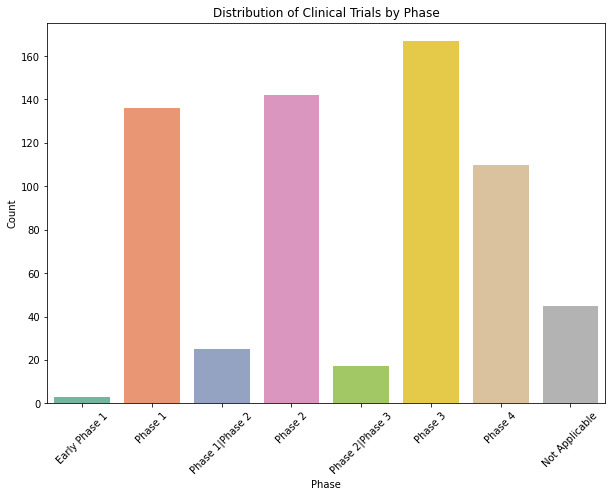

In [39]:
# Plot the distribution of clinical trials by phase

# Select only 'NCTId' and 'Phase' columns
phase_df = vax_trials_filtered[['NCTId', 'Phase']]
phase_df = phase_df.drop_duplicates()


# Define the order for phases
phase_order = ['Early Phase 1', 'Phase 1', 'Phase 1|Phase 2', 'Phase 2', 'Phase 2|Phase 3', 'Phase 3', 'Phase 4', 'Not Applicable']


# Set the figure size
plt.figure(figsize=(10, 7))

# Plot a countplot
sns.countplot(x='Phase', data=phase_df, palette='Set2', order=phase_order)
plt.title('Distribution of Clinical Trials by Phase')
plt.xlabel('Phase')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

- Identify the most frequently reported reasons for patients discontinuing their participation in clinical trials related to vaccine interventions.

In [63]:
# Utilize the 'sum_count' function to extract the 'Reason' and 'DropoutCount' columns from the dataframe
# and sum the values in the 'DropoutCount' column

reason_sum = sum_count(vax_trials_with_dropouts, 'Reason', 'DropoutCount')
reason_sum.head()

,Reason,TotalSum
0,administrative reason,241.0
1,adverse event,563.0
2,ae or death,28.0
3,baseline measles measure high,3.0
4,baseline measure non-negative,73.0


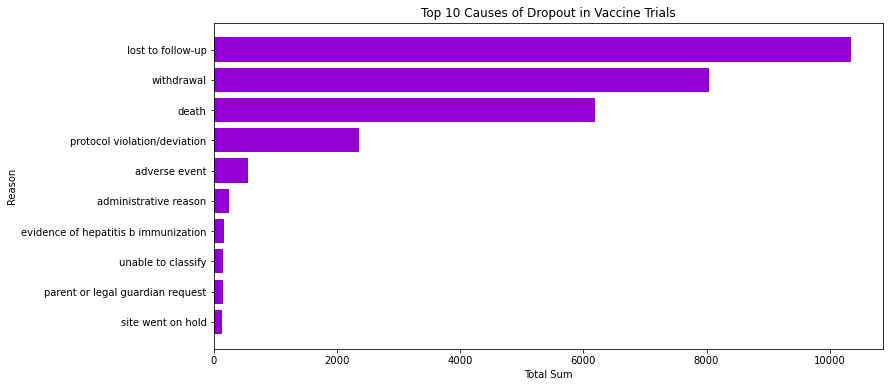

In [41]:
# Plot
dataframe = reason_sum
x_column = 'Reason'
y_column = 'TotalSum'
title = 'Top 10 Causes of Dropout in Vaccine Trials'
xlabel = 'Total Sum'
ylabel = 'Reason'

plot_top_10_sum(dataframe, x_column, y_column, title, xlabel, ylabel)


- Determine the most prevalent conditions in vaccine clinical trials

In [58]:
# Utilize the 'total_count' function to extract the 'NCTId' and 'Condition' columns from the dataframe
# and compute the total count of unique conditions present in the 'Condition' column.


condition_counts = total_count(vax_trials_filtered, 'NCTId', 'Condition')
condition_counts.head()

,Condition,TotalCount
0,influenza,237
1,meningococcal,62
2,sars-cov-2,38
3,dengue,25
4,pneumococcal,24


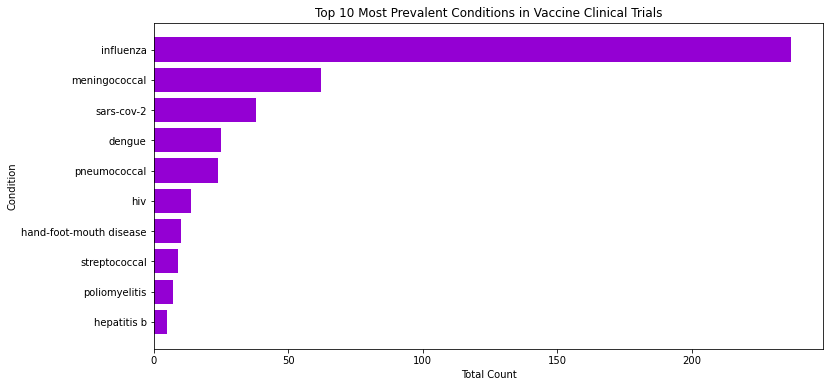

In [59]:
# Plot

dataframe = condition_counts
x_column = 'Condition'
y_column = 'TotalCount'
title = 'Top 10 Most Prevalent Conditions in Vaccine Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Condition'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

- Determine the prevalence of vaccines utilized as interventions in clinical trials 

In [61]:
# Utilize the 'total_count' function to extract the 'NCTId' and 'VaccineName' columns from the dataframe
# and compute the total count of unique vaccines present in the 'VaccineName' column.

interventions_count = total_count(vax_trials_with_interventions, 'NCTId', 'VaccineName')
interventions_count.head()

,VaccineName,TotalCount
0,Placebo,58
1,Influenza vaccine,9
2,13-valent pneumococcal conjugate vaccine,8
3,Placebo Vaccine,7
4,Seasonal Influenza Vaccine,6


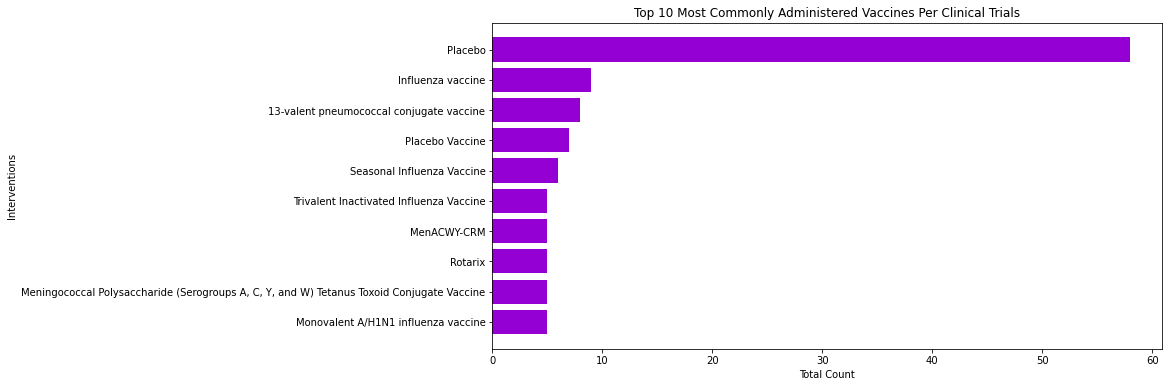

In [62]:
# Plot
dataframe = interventions_count
x_column = 'VaccineName'
y_column = 'TotalCount'
title = 'Top 10 Most Commonly Administered Vaccines Per Clinical Trials'
xlabel = 'Total Count'
ylabel = 'Interventions'

plot_top_10_count(dataframe, x_column, y_column, title, xlabel, ylabel)

- Summary of participants' progress in the study, including the count of those who started and completed the trial.

In [47]:
# use the 'sum_count' function to select the 'Status' and 'Count' columns and sum the values in the 'Count' column

status_sum = sum_count(vax_trials_with_milestones, 'Status', 'StatusCount')
status_sum.head()

,Status,TotalSum
0,baseline negative,1460.0
1,baseline negative with outside vaccination cen...,1331.0
2,completed,438213.0
3,did not start treatment,1.0
4,dose 1,1255.0


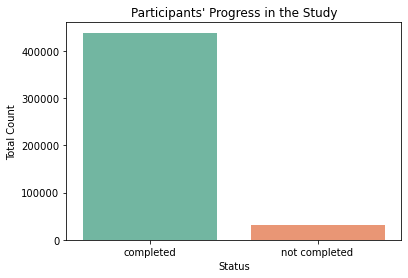

In [48]:
# Filter rows where the 'Title' column is either 'completed' or 'not completed'
status_filtered = status_sum[status_sum['Status'].isin(['completed', 'not completed'])]

# Plot a barplot
sns.barplot(x='Status', y='TotalSum', data=status_filtered, palette='Set2')
plt.title('Participants\' Progress in the Study')
plt.xlabel('Status')
plt.ylabel('Total Count')
plt.show()


### Preprocess the data

In [49]:
# Missing values

vax_trials_with_dropouts.isnull().sum()

NCTId              0
Phase              6
Condition          0
EnrollmentCount    0
OverallStatus      0
Reason             0
DropoutCount       0
dtype: int64

In [50]:
# Select the variables for further analysis

cols = ['NCTId', 'Reason', 'Condition']
df = vax_trials_with_dropouts[cols].dropna()
df.shape 

(775, 3)

In [51]:
df.head()

,NCTId,Reason,Condition
0,NCT02915302,adverse event,influenza
2,NCT02915302,protocol violation/deviation,influenza
4,NCT02915302,lost to follow-up,influenza
6,NCT02915302,withdrawal,influenza
8,NCT02915302,others,influenza


In [52]:
# dummy variables
df = pd.get_dummies(df, columns=['Reason', 'Condition'], prefix=['Reason', 'Condition'])
df.head()

,NCTId,Reason_administrative reason,Reason_adverse event,Reason_ae or death,Reason_baseline measles measure high,Reason_baseline measure non-negative,Reason_case report forms uncollected,Reason_change in cll treatment,Reason_child relocated,Reason_clinical hold,...,Condition_respiratory syncytial virus prevention,Condition_safety and tolerability|compare shingrix vaccine response rates|chronic lymphocytic leukemia (cll)|small lymphocytic lymphoma (sll),Condition_sars-cov-2,Condition_stage iii ovarian cancer|stage iv ovarian cancer,Condition_streptococcal,Condition_tetanus|diphtheria|pertussis|whooping cough,Condition_tularemia,Condition_vaccine response impaired,Condition_virus diseases|rna virus infections|respiratory tract diseases|respiratory tract infections,Condition_west nile fever
0,NCT02915302,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,NCT02915302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NCT02915302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,NCT02915302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,NCT02915302,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
